In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import CountVectorizer
from wilds.common.data_loaders import get_train_loader
import torchvision.transforms as transforms
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("all_data_with_identitiesEmbedded.csv")

In [3]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

In [4]:

df = df.loc[:, ["comment_text", "split", "na_gender", "na_race", "toxicity", "male", "female", "transgender", "black", "white", "asian", "latino"]]

df['toxicity'] = df['toxicity'].apply(lambda score: np.round(score))
df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

df['male'] = df['male'].apply(lambda x: round(x))
df['female'] = df['female'].apply(lambda x: round(x))
df['transgender'] = df['transgender'].apply(lambda x: round(x))
df['black'] = df['black'].apply(lambda x: round(x))
df['white'] = df['white'].apply(lambda x: round(x))
df['asian'] = df['asian'].apply(lambda x: round(x))
df['latino'] = df['latino'].apply(lambda x: round(x))

In [5]:
# Updating values for training_data
training_data = df[df['split'] == 'train']
training_data = training_data[(training_data['na_gender'] == 0) | (training_data['na_race'] == 0)]

# Getting test_data
test_data = df[df['split'] == 'test']
test_data = test_data[(test_data['na_gender'] == 0) | (test_data['na_race'] == 0)]

# Getting validation_data
validation_data = df[df['split'] == 'val']
validation_data = validation_data[(validation_data['na_gender'] == 0) | (validation_data['na_race'] == 0)]

In [6]:
X_train = training_data['comment_text'].values.tolist()
Y_train = training_data['toxicity'].values.tolist()

X_test = test_data['comment_text'].values.tolist()
Y_test = test_data['toxicity'].values.tolist()

X_val = validation_data['comment_text'].values.tolist()
Y_val = validation_data['toxicity'].values.tolist()

In [7]:
class AdalineGDPrivate():
    def __init__(self, learning_rate = 0.01, n_iter = 20, w = None):
        self.w = w
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        
    def CheckAccuracy(self, predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)
    
    def predict(self, X_test):
        # Making sure that array is numpy array
        X_test = np.array(X_test).reshape((len(X_test), -1))
        output = np.dot(X_test, self.w)
        # Sigmoid giving 0-1 results
        
        preds = np.round(1/(1+np.exp(-output)))
        return preds
    
    def PredictTestSetDemographic(self, dfTest):
        dic = {}
        for col in dfTest.columns[5:]:
            tempSet = dfTest[dfTest[col] == 1]
            tempLabels = tempSet['toxicity'].values.tolist()
            tempVecs = tempSet['comment_text'].values.tolist()
            dic[col] = [tempVecs, tempLabels]
        
        accuracies = []
        for col in dic:
            tempPredictions = self.predict(dic[col][0])
            currentAccuracy = self.CheckAccuracy(tempPredictions, dic[col][1])
            accuracies.append([currentAccuracy, col])
        
        accuracies = np.array(accuracies)
        return accuracies
    
    def addNoise(self, X_train):
        #Inspiration from https://www.researchgate.net/post/How-to-add-some-noise-data-to-my-classification-datasets
        #Find standard deviation
        std = np.std(X_train, axis=1)
        
        #Choose number to scale added noise by
        epsilon = 0.1
        
        #Add noise to each entrance in each row
        for i in range(len(std)):
            noise = np.random.uniform(-std[i], std[i], len(X_train[i]))
            X_train[i] += (noise * epsilon)
        return X_train
        
    def fit(self, X_train, Y_train, X_val, Y_val):
        # Making sure that arrays are numpy arrays
        X_train = np.array(X_train).reshape((len(X_train), -1))
        Y_train = np.array(Y_train).reshape((len(Y_train), 1))
        
        X_val = np.array(X_val).reshape((len(X_val), -1))
        Y_val = np.array(Y_val).reshape((len(Y_val), 1))
        
        #Add noise to traning data
        X_train = self.addNoise(X_train)
        
        # Initializing w vector using random normal distribution
        if self.w == None:
            self.w = np.random.normal(0, 0.1, len(X_train[0])).reshape(len(X_train[0]), 1)
        
        badEpoch = 0
        self.bestW = self.w
        bestAcc = 0
        early_stopping = 5
        
        # Using n epochs
        for i in range(self.n_iter):
            output = 1/(1+np.exp(-np.dot(X_train, self.w)))
            error = (Y_train - output)
            self.w += (1/len(Y_train)) * self.learning_rate * np.dot(X_train.T, error)
        
            tmpPreds = self.predict(X_val)
            acc = self.CheckAccuracy(tmpPreds, Y_val)
            
            # Saving the best model and also checks for Early_Stopping
            if acc > bestAcc:
                bestAcc = acc
                badEpoch = 0
                self.bestW = self.w
            else:
                badEpoch += 1
            
            if badEpoch >= early_stopping:
                self.w = self.bestW                
                print("Stopped cause of bad Epoch in iteration: ", i)
                break
            #Print status
            if (i % 100) == 0:
                print('Iteration ', i, ' Done')
        return self

In [8]:
model = AdalineGDPrivate(learning_rate = 0.0001, n_iter = 1000)

model.fit(X_train, Y_train, X_val, Y_val)

predictions = model.predict(X_test)


Y_test = np.array(Y_test).reshape(len(Y_test), 1)
model.CheckAccuracy(predictions, Y_test)

Iteration  0  Done
Iteration  100  Done
Iteration  200  Done
Iteration  300  Done
Iteration  400  Done
Stopped cause of bad Epoch in iteration:  494


0.8547973319651103

In [9]:
forBarPlot = model.PredictTestSetDemographic(test_data)

In [10]:
np.std(forBarPlot[:,0].astype(float))

0.05230670044143701

<ipython-input-11-b3e39705347d>:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.bar(x_pos, y, color='rgbkymc')


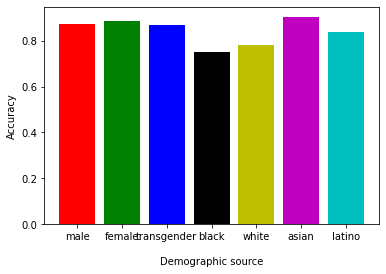

In [11]:
forBarPlot = model.PredictTestSetDemographic(test_data)
plt.figure()
x = forBarPlot[:,1]
y = np.array(forBarPlot[:,0].astype(float))
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y, color='rgbkymc')
plt.xlabel("\nDemographic source")
plt.ylabel("Accuracy")
plt.xticks(x_pos, x)
plt.show()

In [12]:
forBarPlot

array([['0.8739973522311346', 'male'],
       ['0.8871228274213349', 'female'],
       ['0.8669724770642202', 'transgender'],
       ['0.7524883875248839', 'black'],
       ['0.7806391970417327', 'white'],
       ['0.9024597116200169', 'asian'],
       ['0.8356997971602435', 'latino']], dtype='<U32')

In [13]:
np.std(forBarPlot[:,0].astype(float))

0.05230670044143701